In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt

<img src='img/optimizers.png' />

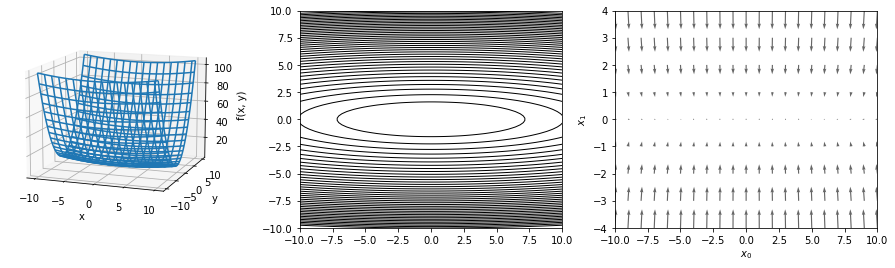

In [2]:
def f(x, y):
    return x**2 / 20 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')

X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
Z = f(X , Y)

# wireframe
ax1.plot_wireframe(X, Y, Z, rstride=3, cstride=6)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')
ax1.view_init(elev=12., azim=-70.)

# contour
ax2 = fig.add_subplot(1,3,2)
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
ax2.contour(X, Y, Z, np.linspace(0,100,40), colors='black', linewidths=1)

# quiver
ax3 = fig.add_subplot(1,3,3)
x0 = np.arange(-10, 11, 1)
x1 = np.arange(-4, 5, 1)
X, Y = np.meshgrid(x0, x1)
X = X.flatten()
Y = Y.flatten()
grad_x, grad_y = df(X, Y)

ax3.quiver(X, Y, -grad_x, -grad_y, angles="xy",color="#666666")
ax3.set_xlim([-10, 10])
ax3.set_ylim([-4, 4])
ax3.set_xlabel('$x_0$')
ax3.set_ylabel('$x_1$')
ax3.grid(False)
plt.show()

In [3]:
def plot_optimizer(optimizer):


    init_pos = (-7.0, 2.0)
    params = {}
    params['x'], params['y'] = init_pos[0], init_pos[1]
    grads = {}
    grads['x'], grads['y'] = 0, 0

    x_history = []
    y_history = []

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)


    x = y = np.arange(-10, 10, 0.01)
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    plt.figure(figsize=(10,5))
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z, np.arange(0,10,1))
    plt.axis('equal')
    plt.xlim(-10, 10)
    plt.ylim(-5, 5)
    plt.plot(0, 0, '+')
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## Ⅰ. SGD

$$
\mathbf{W} \leftarrow \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}
$$

In [4]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        for param in params:
            params[param] -= self.lr * grads[param]

* 단점 : 비등방성 함수에서 탐색 경로가 비효율적

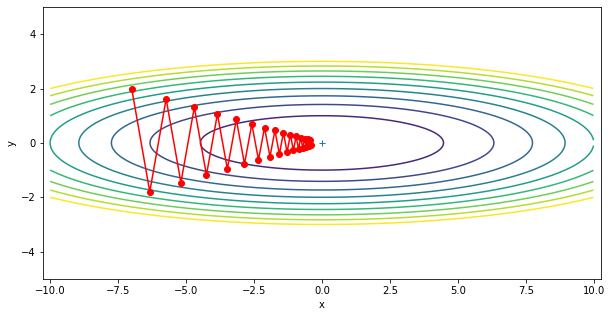

In [5]:
plot_optimizer(SGD(lr=0.95))

## Ⅱ. Momentum

$$
\mathbf{v} \leftarrow \alpha \mathbf{v} - \eta \frac{L}{\mathbf{W}}\\
\mathbf{W} \leftarrow \mathbf{W} + \mathbf{v}
$$

* 일종의 관성을 주는 방식

In [6]:
class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params:
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

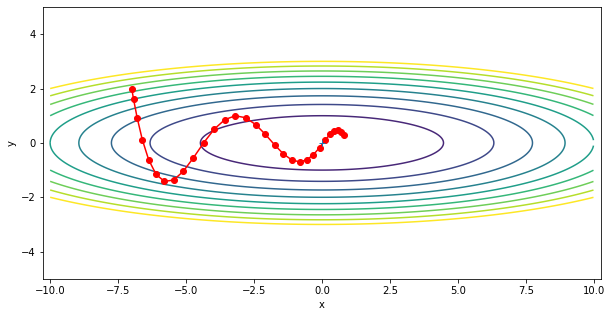

In [7]:
plot_optimizer(Momentum(lr=0.1))

## Ⅲ. Nesterov Accelerated Gradient

<br>
  
* Momentum을 향상시킨 기법, momentum값과 gradient값을 더해 step 방향을 정하는 모멘텀과 달리 momentum값이 적용된 지점에서 gradient값이 계산하여 step


<img src='../img/nag.png' />

<br>

<img src='../img/nag2.png' />

$$
v \leftarrow \alpha v - \eta \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} \leftarrow \mathbf{W} + \alpha v - \eta \frac{\partial L}{\partial \mathbf{W}}
$$

In [8]:
class Nesterov:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params:
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.momentum * self.v[key] - self.lr * grads[key]

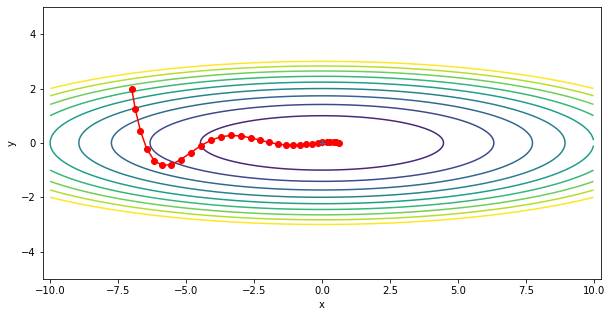

In [9]:
plot_optimizer(Nesterov(lr=0.1))

## Ⅳ. AdaGrad

* 개별 매개변수에 적응적으로 학습률을 조정

$$
\mathbf{h} \leftarrow \mathbf{h} + \frac{\partial L}{\partial \mathbf{W}} * \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} \leftarrow \mathbf{W} - \eta \frac{1}{\mathbf{\sqrt{h} +\epsilon}} \frac{\partial L}{\partial \mathbf{W}}
$$

In [10]:
class AdaGrad:
    
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        # initialize h
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        # update
        for key in params:
            self.h[key] += grads[key]**2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

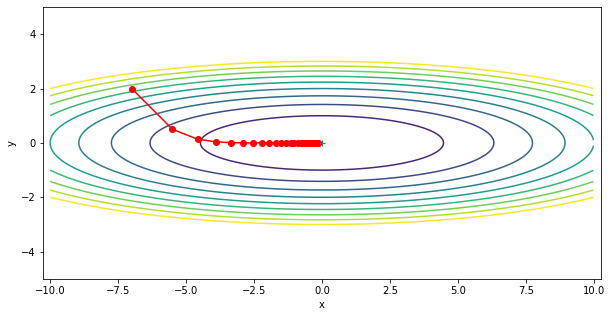

In [11]:
plot_optimizer(AdaGrad(lr=1.5))

## Ⅴ. RMSProp

* AdaGrad는 과거의 기울기를 단순 누적하지 하기 때문에 학습이 진행할수록 갱신 강도가 약해짐
* RMSProp은 이 문제를 개선한 기법으로 지수이동평균(EMA)을 사용하여 최신 기울기들이 더 크게 반영함

$$
\mathbf{h} \leftarrow \rho \, \mathbf{h} + (1- \rho) \frac{\partial L}{\partial \mathbf{W}} * \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} \leftarrow \mathbf{W} - \eta \frac{1}{\mathbf{\sqrt{h+\epsilon}}} \frac{\partial L}{\partial \mathbf{W}}
$$

In [12]:
class RMSprop:

    def __init__(self, lr=0.01, decay_rate=0.9):
        self.lr = lr
        self.h = None
        self.decay_rate = decay_rate
        
    def update(self, params, grads):
        # initialize h
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        # update
        for key in params:
            self.h[key] = self.decay_rate * self.h[key] + (1 - self.decay_rate) * grads[key]**2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]+ 1e-7))

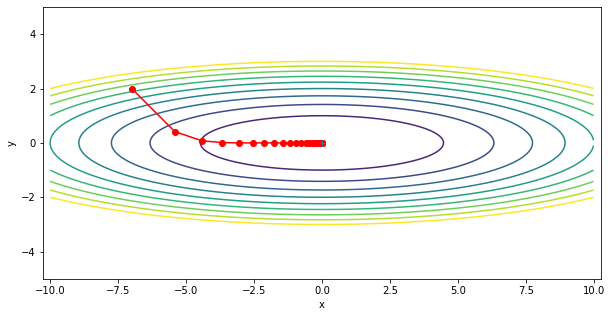

In [13]:
plot_optimizer(RMSprop(lr=0.5))

## Ⅵ. AdaDelta

* RMSProp와 비슷하게 AdaGrad의 문제점을 해결
* learning rate를 따로 설정할 필요성이 없음

$$
\mathbf{h} \leftarrow \rho \, \mathbf{h} + (1- \rho) \frac{\partial L}{\partial \mathbf{W}} * \frac{\partial L}{\partial \mathbf{W}} \\
\Delta \mathbf{W} \leftarrow \frac{\mathbf{\sqrt{s+\epsilon}}}{\mathbf{\sqrt{h+\epsilon}}} \frac{\partial L}{\partial \mathbf{W}}
$$
<br>
$$
\mathbf{W} \leftarrow \mathbf{W} - \Delta \mathbf{W}\\
\mathbf{s} \leftarrow \rho \, \mathbf{s} + (1- \rho) \Delta \mathbf{W} * \Delta \mathbf{W} \\
$$

In [14]:
class AdaDelta:

    def __init__(self, lr=1.0, decay_rate=0.9):
        self.h = None
        self.s = None
        self.lr = lr
        self.decay_rate = decay_rate
        
    def update(self, params, grads):
        # initialize h, s
        if self.h is None:
            self.h = {}
            self.s = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                self.s[key] = np.zeros_like(val)
        
        for key in params:

            # update h
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]

            # calculate dW
            #print(np.sqrt((self.s[key] + 1e-6)/(self.h[key] + 1e-6)))
            dx = -grads[key] * np.sqrt((self.s[key] + 1e-6)/(self.h[key] + 1e-6))

            # update W
            params[key] += self.lr * dx
            
            # update s
            self.s[key] *= self.decay_rate
            self.s[key] += (1 - self.decay_rate) * dx * dx

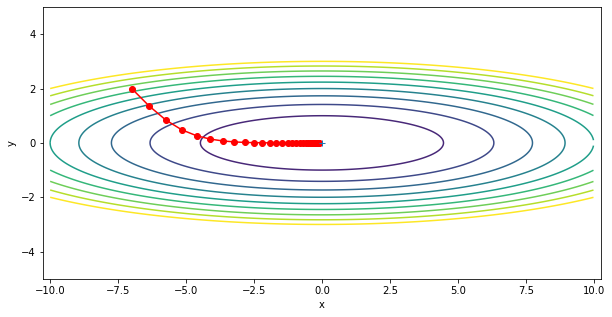

In [15]:
plot_optimizer(AdaDelta(lr=200.0))

## Ⅶ. Adam

* RMSProp과 Momentum 기법을 융합한 기법
* 초기값을 0으로 준것에 대한 bias correction을 함
<br>
<br>
$$
t \leftarrow t+1\\
m \leftarrow \beta_1 m + (1-\beta_1)\frac{\partial L}{\partial W}\\
v \leftarrow \beta_2 v + (1-\beta_2)(\frac{\partial L}{\partial W})^2\\
\\
\hat m = \frac{m}{1-\beta_1^t}\\
\hat v = \frac{v}{1-\beta_2^t}\\
\\
\mathbf{W} \leftarrow \mathbf{W} - \frac{\eta}{\sqrt{\hat v + \epsilon}}\hat m
$$


In [16]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            
            # update moments
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            
            # bias correction
            unbias_m = self.m[key] / (1-self.beta1**self.iter)
            unbias_b = self.v[key] / (1-self.beta2**self.iter)
            
            # update
            params[key] -= self.lr * unbias_m / (np.sqrt(unbias_b) + 1e-7)

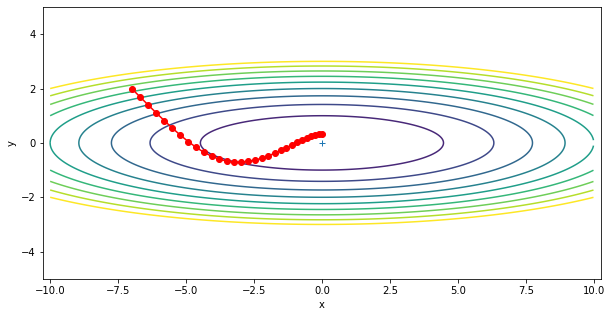

In [17]:
plot_optimizer(Adam(lr=0.3))

Adam을 개선한 optimizers들도 많이 있다.

* [RAdam](https://github.com/LiyuanLucasLiu/RAdam)  
* [AdamP](https://github.com/clovaai/AdamP)
    

## Ⅷ. MNIST 비교

In [18]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['Nesterov'] = Nesterov()
optimizers['AdaGrad'] = AdaGrad()
optimizers['RMSprop'] = RMSprop()
optimizers['AdaDelta'] = AdaDelta()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers:
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers:
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if (i+1) % 500 == 0:
        print( "===========" + "iteration:" + str(i+1) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:500===========
SGD:0.28900640961667434
Momentum:0.09179256090189891
Nesterov:0.07956205051379478
AdaGrad:0.03162422781212343
RMSprop:0.022519082858613537
AdaDelta:0.013855694881259087
Adam:0.04541712972681576
===========iteration:1000===========
SGD:0.2961003013408243
Momentum:0.10969952420736684
Nesterov:0.09455612766728007
AdaGrad:0.04972661652219959
RMSprop:0.17628472728366074
AdaDelta:0.02639397661345413
Adam:0.07712203216151366
===========iteration:1500===========
SGD:0.2812197815945634
Momentum:0.10520670503813734
Nesterov:0.13125660547664347
AdaGrad:0.08370226396733306
RMSprop:0.035743801961281046
AdaDelta:0.06984694849306555
Adam:0.09092658081186634
===========iteration:2000===========
SGD:0.14821750942883194
Momentum:0.03633625474683569
Nesterov:0.047408858034943546
AdaGrad:0.019920854425201605
RMSprop:0.012591150116323755
AdaDelta:0.0018197034211697638
Adam:0.022745426813040634


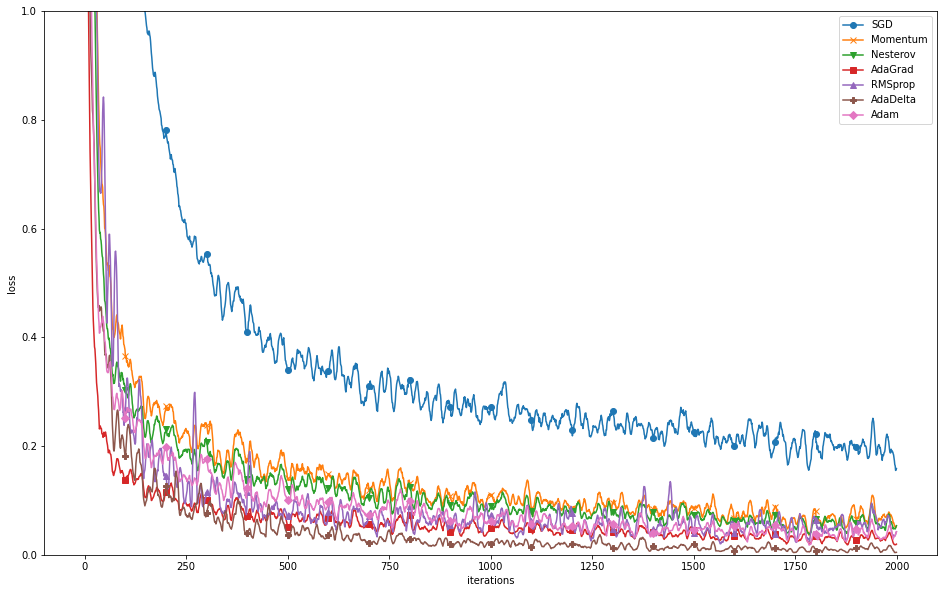

In [19]:
markers = {"SGD": "o", "Momentum": "x", 'Nesterov':'v', "AdaGrad": "s", 'RMSprop':'^', 'AdaDelta':'P', "Adam": "D"}
x = np.arange(max_iterations)
plt.figure(figsize=(16,10))
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()